#Installations

In [15]:
!pip install scorecardpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60629 sha256=325e691a8b681884c09a4eb905ee23a51dd7e0659c0a2fcbfe6fbc25e54f29de
  Stored in directory: /root/.cache/pip/wheels/9f/d8/4e/61a6f4e78fe6700f66b699ab38377f0aa5b33e3ef55751ba38
Successfully built scorecardpy


In [18]:
import pandas as pd
import numpy as np
import scorecardpy as sc

#Data Understanding

In [1]:
# column names (example)
col_names = [
 "account_status","duration","credit_history","purpose",
 "credit_amount","savings","employment","installment_rate",
 "personal_status","guarantors","residence","property",
 "age","other_installments","housing","credit_cards",
 "job","dependents","phone","foreign_worker","class"
]

df = pd.read_csv("german.data", sep=" ", header=None, names=col_names)


In [3]:
df.head()

,account_status,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status,guarantors,...,property,age,other_installments,housing,credit_cards,job,dependents,phone,foreign_worker,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [6]:
df.shape

(1000, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   account_status      1000 non-null   object
 1   duration            1000 non-null   int64 
 2   credit_history      1000 non-null   object
 3   purpose             1000 non-null   object
 4   credit_amount       1000 non-null   int64 
 5   savings             1000 non-null   object
 6   employment          1000 non-null   object
 7   installment_rate    1000 non-null   int64 
 8   personal_status     1000 non-null   object
 9   guarantors          1000 non-null   object
 10  residence           1000 non-null   int64 
 11  property            1000 non-null   object
 12  age                 1000 non-null   int64 
 13  other_installments  1000 non-null   object
 14  housing             1000 non-null   object
 15  credit_cards        1000 non-null   int64 
 16  job                 1000 

In [8]:
df.isna().sum()

,0
account_status,0
duration,0
credit_history,0
purpose,0
credit_amount,0
savings,0
employment,0
installment_rate,0
personal_status,0
guarantors,0


In [7]:
df['class'].value_counts(normalize=True)

,proportion
class,
1,0.7
2,0.3


##Credit Policy Rules

These rules come directly from credit policy, not statistics.

In [9]:
# Duration must be positive
assert (df['duration'] > 0).all(), "Invalid loan duration detected"

# Credit amount must be strictly positive
assert (df['credit_amount'] > 0).all(), "Invalid credit amount detected"

# Installment rate: percentage of disposable income (1–4 in this dataset)
assert df['installment_rate'].between(1, 4).all(), "Invalid installment rate"

# Age: legal lending age
assert (df['age'] >= 18).all(), "Underage applicant detected"

# Number of credits & dependents
assert (df['credit_cards'] >= 0).all()
assert (df['dependents'] >= 0).all()


In [10]:
expected_categories = {
    "account_status": {"A11","A12","A13","A14"},
    "credit_history": {"A30","A31","A32","A33","A34"},
    "purpose": {"A40","A41","A42","A43","A44","A45","A46","A48","A49","A410"},
    "savings": {"A61","A62","A63","A64","A65"},
    "employment": {"A71","A72","A73","A74","A75"},
    "personal_status": {"A91","A92","A93","A94","A95"},
    "guarantors": {"A101","A102","A103"},
    "property": {"A121","A122","A123","A124"},
    "other_installments": {"A141","A142","A143"},
    "housing": {"A151","A152","A153"},
    "job": {"A171","A172","A173","A174"},
    "phone": {"A191","A192"},
    "foreign_worker": {"A201","A202"},
}

for col, allowed in expected_categories.items():
    invalid = set(df[col].unique()) - allowed
    assert len(invalid) == 0, f"Invalid category in {col}: {invalid}"


#Data Preparation & Feature Engineering (WoE + IV)

In [12]:
df = df.copy()

# Target: 1 = default (bad credit), 0 = good credit
df['target'] = (df['class'] == 2).astype(int)

# Drop original label
df.drop(columns=['class'], inplace=True)

df[['target']].value_counts(normalize=True)


,proportion
target,
0,0.7
1,0.3


In [13]:
# Numerical sanity checks
assert (df['duration'] > 0).all(), "Invalid duration detected"
assert (df['credit_amount'] > 0).all(), "Invalid credit amount detected"
assert df['installment_rate'].between(1, 4).all(), "Invalid installment rate"
assert (df['age'] >= 18).all(), "Underage applicant detected"
assert (df['credit_cards'] >= 0).all()
assert (df['dependents'] >= 0).all()


In [14]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


In [16]:
train_df = X_train.copy()
train_df['target'] = y_train

In [19]:
bins = sc.woebin(
    train_df,
    y='target',
    method='tree',
    max_num_bin=5
)

[INFO] creating woe binning ...


/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is

##Check Information Value (feature strength)

In [20]:
iv = sc.iv(train_df, y='target')
iv.sort_values(by='info_value', ascending=False)

,variable,info_value
11,account_status,0.638775
2,duration,0.275968
3,age,0.271182
12,credit_history,0.254391
15,savings,0.233467
9,employment,0.140286
14,property,0.140196
1,purpose,0.132244
10,other_installments,0.116911
13,housing,0.102040


In [21]:
X_train_woe = sc.woebin_ply(X_train, bins)
X_test_woe  = sc.woebin_ply(X_test, bins)


[INFO] converting into woe values ...
[INFO] converting into woe values ...


“Although dependents and residence are conceptually related to repayment capacity and stability, the IV analysis shows they have essentially no predictive power in this dataset. In practice, these features might matter in certain portfolios, but for this model they are safely dropped without loss of accuracy.”

In [24]:
#Drop immediately (IV < 0.02):
low_iv_vars = [
    'dependents_woe',
    'residence_woe',
    'phone_woe',
    'credit_cards_woe'
]

X_train_woe.drop(columns=low_iv_vars, inplace=True)
X_test_woe.drop(columns=low_iv_vars, inplace=True)


In [25]:
X_train_woe.head()


,purpose_woe,duration_woe,credit_amount_woe,job_woe,personal_status_woe,employment_woe,credit_history_woe,foreign_worker_woe,age_woe,guarantors_woe,installment_rate_woe,other_installments_woe,account_status_woe,housing_woe,property_woe,savings_woe
10,0.169189,-0.339283,-0.269664,-0.039556,0.25573,0.604068,0.082842,0.0,0.455256,0.0,0.136819,-0.174622,0.318039,0.468861,0.034804,0.301787
82,0.169189,0.176130,-0.269664,-0.104261,0.25573,-0.074691,0.082842,0.0,0.455256,0.0,0.136819,-0.174622,-1.184134,0.468861,-0.051449,0.098061
827,0.169189,0.176130,0.896088,-0.039556,-0.16342,-0.074691,1.090920,0.0,-0.415617,0.0,-0.211784,0.308301,-1.184134,-0.214468,0.034804,0.301787
410,-0.384846,0.176130,-0.269664,-0.039556,0.25573,-0.194156,0.082842,0.0,0.455256,0.0,0.136819,-0.174622,0.318039,-0.214468,0.034804,0.301787
48,0.169189,-0.339283,-0.035091,-0.104261,-0.16342,-0.074691,-0.699082,0.0,-0.415617,0.0,-0.292136,-0.174622,-1.184134,-0.214468,-0.051449,0.301787


#Modeling & Evaluation

In [26]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train_woe, y_train)

# Coefficients
pd.DataFrame({
    'feature': X_train_woe.columns,
    'coef': lr.coef_[0]
}).sort_values(by='coef', ascending=False)


,feature,coef
10,installment_rate_woe,1.406124
2,credit_amount_woe,0.971828
0,purpose_woe,0.924171
4,personal_status_woe,0.872592
15,savings_woe,0.800989
1,duration_woe,0.799886
12,account_status_woe,0.777980
11,other_installments_woe,0.763171
5,employment_woe,0.662834
6,credit_history_woe,0.580842


Confusion Matrix:

                 Predicted Good (0)  Predicted Bad (1)
Actual Good (0)                 182                 28
Actual Bad (1)                   53                 37


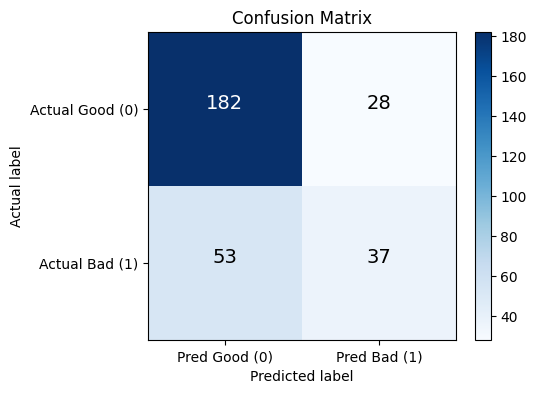


Total Misclassification Cost: 293

ROC-AUC: 0.7967195767195767


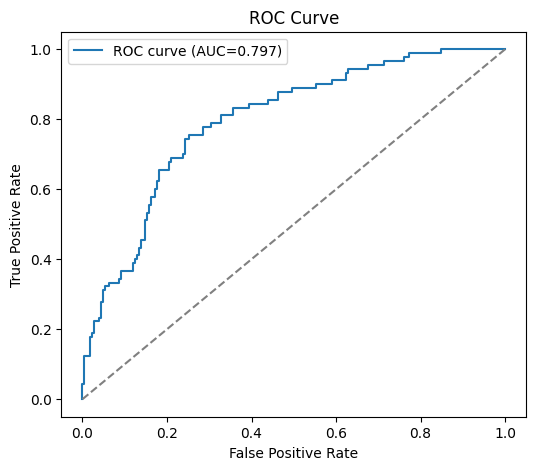

Gini Coefficient: 0.5934391534391534
KS Statistic: 0.5031746031746032


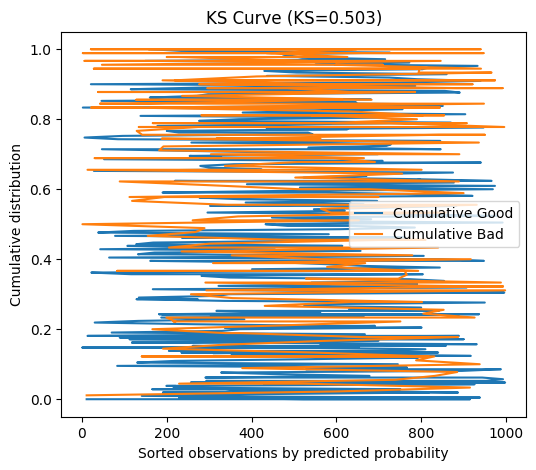


Classification Report:

              precision    recall  f1-score   support

    Good (0)       0.77      0.87      0.82       210
     Bad (1)       0.57      0.41      0.48        90

    accuracy                           0.73       300
   macro avg       0.67      0.64      0.65       300
weighted avg       0.71      0.73      0.72       300



In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report

# -------------------------------
# 1️⃣ Predictions
# -------------------------------
y_pred_proba = lr.predict_proba(X_test_woe)[:, 1]  # probability of bad credit
y_pred_class = lr.predict(X_test_woe)             # binary prediction using 0.5 cutoff

# -------------------------------
# 2️⃣ Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred_class)
cm_df = pd.DataFrame(cm,
                     index=['Actual Good (0)', 'Actual Bad (1)'],
                     columns=['Predicted Good (0)', 'Predicted Bad (1)'])

print("Confusion Matrix:\n")
print(cm_df)

# Plot confusion matrix
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Pred Good (0)', 'Pred Bad (1)'])
plt.yticks(tick_marks, ['Actual Good (0)', 'Actual Bad (1)'])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Misclassification cost (Good->Bad = 1, Bad->Good = 5)
cost = cm[0,1]*1 + cm[1,0]*5
print("\nTotal Misclassification Cost:", cost)

# -------------------------------
# 3️⃣ ROC-AUC
# -------------------------------
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

print("\nROC-AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# -------------------------------
# 4️⃣ Gini Coefficient
# -------------------------------
gini = 2 * roc_auc - 1
print("Gini Coefficient:", gini)

# -------------------------------
# 5️⃣ KS Statistic (manual calculation)
# -------------------------------
# Sort by predicted probability
df_ks = pd.DataFrame({'y_true': y_test, 'y_prob': y_pred_proba})
df_ks = df_ks.sort_values(by='y_prob', ascending=False)
df_ks['cum_good'] = (df_ks['y_true']==0).cumsum() / (df_ks['y_true']==0).sum()
df_ks['cum_bad']  = (df_ks['y_true']==1).cumsum() / (df_ks['y_true']==1).sum()
ks_stat = max(abs(df_ks['cum_bad'] - df_ks['cum_good']))
print("KS Statistic:", ks_stat)

# Optional: plot KS curve
plt.figure(figsize=(6,5))
plt.plot(df_ks['cum_good'], label='Cumulative Good')
plt.plot(df_ks['cum_bad'], label='Cumulative Bad')
plt.title(f'KS Curve (KS={ks_stat:.3f})')
plt.xlabel('Sorted observations by predicted probability')
plt.ylabel('Cumulative distribution')
plt.legend()
plt.show()

# -------------------------------
# 6️⃣ Classification Report
# -------------------------------
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_class, target_names=['Good (0)', 'Bad (1)']))


Optimal Threshold: 0.22
Minimum Total Misclassification Cost: 151


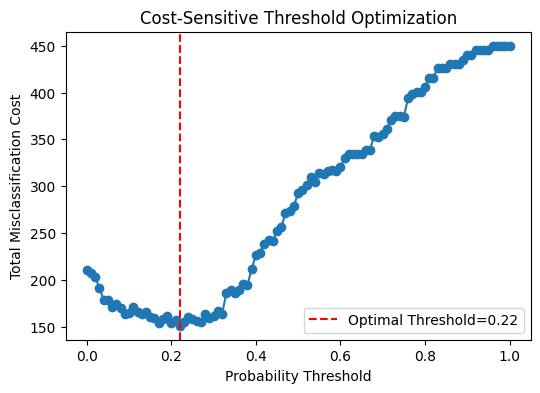


Confusion Matrix at Optimal Threshold:

                 Predicted Good (0)  Predicted Bad (1)
Actual Good (0)                 134                 76
Actual Bad (1)                   15                 75

Classification Report at Optimal Threshold:

              precision    recall  f1-score   support

    Good (0)       0.90      0.64      0.75       210
     Bad (1)       0.50      0.83      0.62        90

    accuracy                           0.70       300
   macro avg       0.70      0.74      0.68       300
weighted avg       0.78      0.70      0.71       300



In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define thresholds to test
thresholds = np.arange(0.0, 1.01, 0.01)

# Initialize list to store total misclassification costs
costs = []

# Cost matrix: Good->Bad = 1, Bad->Good = 5
for t in thresholds:
    y_pred_thresh = (y_pred_proba >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    total_cost = cm[0,1]*1 + cm[1,0]*5
    costs.append(total_cost)

# Find threshold with minimum cost
optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = costs[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Minimum Total Misclassification Cost: {min_cost}")

# Plot cost vs threshold
plt.figure(figsize=(6,4))
plt.plot(thresholds, costs, marker='o')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold={optimal_threshold:.2f}')
plt.xlabel('Probability Threshold')
plt.ylabel('Total Misclassification Cost')
plt.title('Cost-Sensitive Threshold Optimization')
plt.legend()
plt.show()

# -------------------------------
# Apply optimal threshold
# -------------------------------
y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)
cm_opt = confusion_matrix(y_test, y_pred_opt)
cm_opt_df = pd.DataFrame(cm_opt,
                         index=['Actual Good (0)', 'Actual Bad (1)'],
                         columns=['Predicted Good (0)', 'Predicted Bad (1)'])

print("\nConfusion Matrix at Optimal Threshold:\n")
print(cm_opt_df)

# Optional: updated classification report
from sklearn.metrics import classification_report
print("\nClassification Report at Optimal Threshold:\n")
print(classification_report(y_test, y_pred_opt, target_names=['Good (0)', 'Bad (1)']))


Good applicants: precision = 0.90 → most predicted good are truly good

Good recall drops: 0.64 → some good customers are now flagged as bad (false positives)

Bad applicants: recall = 0.83 → much better, catching 83% of risky customers ✅

This directly reduces the costly False Negatives, which is why your total misclassification cost dropped so much.

KS Statistic (full probabilities): 0.5031746031746032
Gini Coefficient: 0.5934391534391534


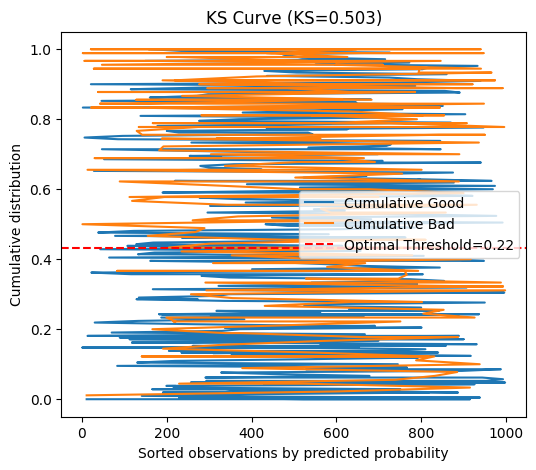

In [36]:
# -------------------------------
# 1️⃣ KS Statistic (manual calculation) - updated
# -------------------------------
df_ks_opt = pd.DataFrame({'y_true': y_test, 'y_prob': y_pred_proba})
df_ks_opt = df_ks_opt.sort_values(by='y_prob', ascending=False)
df_ks_opt['cum_good'] = (df_ks_opt['y_true']==0).cumsum() / (df_ks_opt['y_true']==0).sum()
df_ks_opt['cum_bad']  = (df_ks_opt['y_true']==1).cumsum() / (df_ks_opt['y_true']==1).sum()
ks_stat_opt = max(abs(df_ks_opt['cum_bad'] - df_ks_opt['cum_good']))
print("KS Statistic (full probabilities):", ks_stat_opt)

# -------------------------------
# 2️⃣ Gini Coefficient
# -------------------------------
from sklearn.metrics import roc_auc_score
roc_auc_opt = roc_auc_score(y_test, y_pred_proba)
gini_opt = 2 * roc_auc_opt - 1
print("Gini Coefficient:", gini_opt)

# -------------------------------
# 3️⃣ Optional: KS curve
# -------------------------------
plt.figure(figsize=(6,5))
plt.plot(df_ks_opt['cum_good'], label='Cumulative Good')
plt.plot(df_ks_opt['cum_bad'], label='Cumulative Bad')

# Corrected line using iloc
plt.axhline(y=df_ks_opt['cum_bad'].iloc[int(optimal_threshold*len(df_ks_opt))],
            color='red', linestyle='--', label=f'Optimal Threshold={optimal_threshold:.2f}')

plt.title(f'KS Curve (KS={ks_stat_opt:.3f})')
plt.xlabel('Sorted observations by predicted probability')
plt.ylabel('Cumulative distribution')
plt.legend()
plt.show()

